In [1]:
# Colab 环境检测与依赖安装
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git@main
    !pip install -q git+https://github.com/bud-primordium/AtomPPGen.git@main


# AtomPPGen 教程 04：Kleinman-Bylander 可分离形式

本 Notebook 聚焦如何把半局域通道转换成 Kleinman-Bylander (KB) 可分离势。你将会：
- 在 Colab 或本地快速配置 AtomSCF + AtomPPGen 运行环境；
- 理解从 $O(N_{\mathrm{PW}}^2)$ 降到 $O(N_{\mathrm{PW}})$ 的效率提升逻辑；
- 推导并实操 $\beta_l$ 与 $D_l$ 的构造方法；
- 使用 `kb_transform` 获得局域势、投影子及诊断信息，并完成可视化。

建议先完成 03-potential-inversion 教程，确保半局域势已稳定可用。


## 为什么需要 KB 可分离形式？

半局域非局域势写作
$$
V_{\mathrm{NL}}^{\mathrm{SL}} = \sum_{l,m} |Y_l^m\rangle \bigl[V_l(r) - V_{\mathrm{loc}}(r)\bigr] \langle Y_l^m|
$$
在平面波基底中需要对 $(\mathbf{G},\mathbf{G}')$ 的所有组合计算积分，复杂度约为 $O(N_{\mathrm{PW}}^2)$。随着平面波数量 $N_{\mathrm{PW}} \propto E_{\mathrm{cut}}^{3/2}$ 增加，赝势应用成本迅速飙升，并且不同 $l$ 通道之间不能复用计算结果。

KB 可分离形式将每个通道表示为 rank-1 投影：
$$
V_{\mathrm{NL}}^{\mathrm{KB}} = \sum_l |\beta_l\rangle D_l \langle \beta_l|
$$
这样矩阵-向量乘法只需与波函数数目线性相关，复杂度降为 $O(N_{\mathrm{PW}} N_{\mathrm{proj}})$，通常 $N_{\mathrm{proj}}$ 只等于 2-4。相比直接提升平面波截断能（方案一：牺牲效率换准确度），KB 方案（方案二）在保持半局域精度的同时把数值工作集中在少量投影子上，是主流平面波 DFT 代码的共同选择。


## 投影子公式推导：$\beta_l \propto (V_l - V_{\mathrm{loc}})\phi_l$

1. 以选定的局域通道 $V_{\mathrm{loc}}$ 作为背景，把剩余通道的势差写成 $\Delta V_l(r) = V_l(r) - V_{\mathrm{loc}}(r)$。
2. 对应角动量通道的径向规约波函数记为 $\phi_l(r) = u_l(r)/r$，其中 $u_l$ 为 TM 伪轨道或 AE 轨道，满足 $\int |u_l|^2 \mathrm{d}r = 1$。
3. 把半局域势作用在 $|\phi_l\rangle$ 上：
   $$ |\chi_l\rangle = \Delta V_l |\phi_l\rangle $$
   在径向表象下即 $\chi_l(r) = \Delta V_l(r)\,\phi_l(r)$。
4. 为了得到正交归一的投影子，定义
   $$ \beta_l(r) = \frac{\chi_l(r)}{\sqrt{\langle \chi_l|\chi_l \rangle}} = \frac{\bigl[V_l(r) - V_{\mathrm{loc}}(r)\bigr] \phi_l(r)}{\sqrt{\int |\Delta V_l\,\phi_l|^2 w\,\mathrm{d}r}}. $$
   因此 $\beta_l \propto (V_l - V_{\mathrm{loc}})\phi_l$，比例因子由归一化积分确定。
5. 耦合系数采用
   $$ D_l = \frac{\langle \chi_l|\chi_l \rangle}{\langle \phi_l|\Delta V_l|\phi_l \rangle} = \frac{W_l}{Z_l}, $$
   其中 $W_l = \int |\Delta V_l\,\phi_l|^2 w\,\mathrm{d}r$, $Z_l = \int \Delta V_l\,|\phi_l|^2 w\,\mathrm{d}r$。当 $Z_l$ 接近零时意味着局域道选择不当，需要重新选择 $l^*$ 或增加 $r_c$。


## 局域道选择的物理依据

- 高角动量轨道（如 d、f）在核附近受到更强的离心排斥，势能曲线最硬、更接近"屏障"形状。把这类通道当作 $V_{\mathrm{loc}}$，可让其余通道的 $\Delta V_l$ 在截断半径内保持平滑，投影子更局域。
- 价层中最软的 s/p 通道留给非局域投影能够减少幽灵态风险；一旦把 s 通道设为局域势，其它通道需在更硬的背景下构造 $\beta_l$，往往导致 $Z_l \to 0$ 或耦合系数巨大。
- 方案 A（推荐）：选择未占据或弱占据的高 $l$（Al 取 d，过渡金属可取 f），仅需使用较小的 $r_c$ 即可获得平滑投影。
- 方案 B：当体系确实需要把 d 通道纳入可移植性测试时，可改用 p/s 通道做局域势，但必须增大对应通道的 $r_c$ 并重新验证 log-derivative 曲线。

经验法则：局域势应该是所有通道里"最排斥"的一条，以便其它通道在其基础上构造出的 $\Delta V_l$ 带来有限而稳定的耦合。


## `kb_transform` 使用要点

`kb_transform` 负责把 `{V_l(r)}` 与波函数 `{u_l(r)}` 转换成 `KBResult`：

```python
from atomppgen.kb import kb_transform
kb = kb_transform(
    invert_results=invert_dict,   # {l: InvertResult}
    u_by_l={l: u_l for l in invert_dict},
    r=radial_grid,
    w=weights,
    loc_channel=2,
)
```

- `invert_results`：来自 `invert_semilocal_potential` 的半局域势，键必须覆盖所有角动量。
- `u_by_l`：与势相匹配的波函数，推荐直接使用 TM 伪轨道（`tm_result.u_ps`）。
- `loc_channel`：局域通道索引，若不传则默认取 d 道。
- 返回的 `KBResult` 携带 `V_loc`, `beta_l`, `D_l` 以及 `diagnostics`，方便在 Notebook 中打印或绘图。


In [2]:
# 导入依赖与绘图配置
import numpy as np
import matplotlib.pyplot as plt
import platform

from atomppgen import (
    solve_ae_atom,
    tm_pseudize,
    invert_semilocal_potential,
    kb_transform,
)

# 中文字体配置（兼容多平台）
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti']
elif platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
else:  # Linux / Colab
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (7.0, 4.5)


## 实战：Al (Z=13) TM→KB 流程

流程回顾：
1. `solve_ae_atom` 得到 LDA 参考解；
2. 对每个角动量调用 `tm_pseudize` 构造伪轨道；
3. 用 `invert_semilocal_potential` 反演半局域势；
4. 交给 `kb_transform` 得到 KB 可分离形式（局域通道取 d）。


In [3]:
# Al LDA 示例：求解 → TM 伪化 → 势反演 → KB 转换
Z = 13
rc_map = {0: 2.1, 1: 2.2, 2: 2.4}  # s/p/d 截断半径（Bohr）
loc_channel = 2  # d 通道作为局域势
continuity_orders = 4

# 1) 全电子参考解（LDA，自旋无关）
ae = solve_ae_atom(
    Z=Z,
    lmax=max(rc_map.keys()),
    grid_type='exp_transformed',
    spin_mode='LDA',
)

# 2&3) TM 伪化 + 半局域势反演
invert_results = {}
tm_results = {}
for l, rc in rc_map.items():
    # 选取该通道能量最高的参考态（列表末尾；p/d 通道通常为近零散射态）
    u_val = ae.u_by_l[l][-1]
    eps_val = ae.eps_by_l[l][-1]
    tm_res = tm_pseudize(
        r=ae.r,
        w=ae.w,
        u_ae=u_val,
        eps=eps_val,
        l=l,
        rc=rc,
        continuity_orders=continuity_orders,
    )
    tm_results[l] = tm_res
    invert_results[l] = invert_semilocal_potential(tm_res, ae.r)

# 4) KB 可分离形式
ae_like_u = {l: tm_results[l].u_ps for l in invert_results}
kb = kb_transform(
    invert_results=invert_results,
    u_by_l=ae_like_u,
    r=ae.r,
    w=ae.w,
    loc_channel=loc_channel,
)

channel_labels = {0: 's', 1: 'p', 2: 'd'}
print(f"Local channel l* = {kb.loc_channel}, covered channels: {sorted(invert_results.keys())}")
for l in sorted(kb.beta_l.keys()):
    norm = kb.diagnostics['projector_norms'][l]
    print(f"l = {l} ({channel_labels[l]}): W_l = {norm:.3e}, D_l = {kb.D_l[l]:.3f} Ha")


Local channel l* = 2, covered channels: [0, 1, 2]
l = 0 (s): W_l = 1.590e+00, D_l = 4.990 Ha
l = 1 (p): W_l = 7.530e-05, D_l = 2.219 Ha


## 可视化：局域势曲线 $V_{\mathrm{loc}}(r)$

局域势的形状决定了其它通道的 $\Delta V_l$。以下示例展示 d 道（局域势）的径向曲线，并在 $r_c^{(d)}$ 处做标记，检查是否足够平滑且单调。


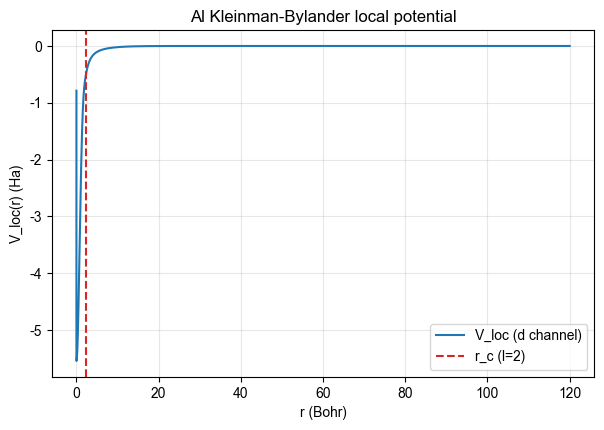

In [4]:
# 绘制局域势
fig, ax = plt.subplots()
ax.plot(kb.r, kb.V_loc, label='V_loc (d channel)')
rc_loc = invert_results[loc_channel].rc
ax.axvline(rc_loc, color='tab:red', linestyle='--', label=f'r_c (l={loc_channel})')
ax.set_xlabel('r (Bohr)')
ax.set_ylabel('V_loc(r) (Ha)')
ax.set_title('Al Kleinman-Bylander local potential')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


## 可视化：各通道投影子 $\beta_l(r)$

根据 $\beta_l \propto (V_l - V_{\mathrm{loc}})\phi_l$，不同角动量的投影子应该在局域势截断半径附近集中并快速衰减。下图比较 s、p 通道的 $\beta_l(r)$，方便检查其局域性与归一化情况。


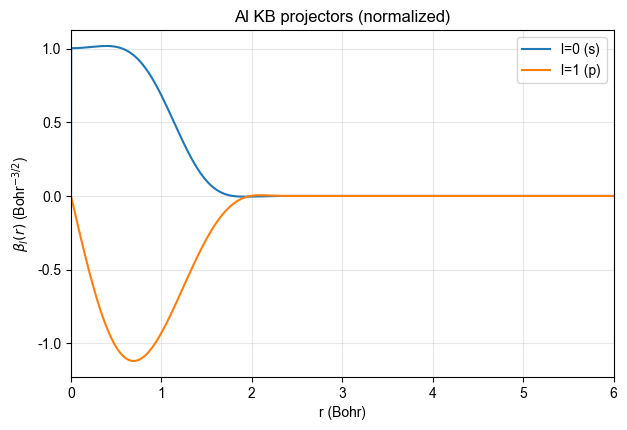

In [5]:
# 绘制投影子 β_l(r)
fig, ax = plt.subplots()
for l, beta in sorted(kb.beta_l.items()):
    ax.plot(kb.r, beta, label=f'l={l} ({channel_labels[l]})')
ax.set_xlim(0.0, 6.0)
ax.set_xlabel('r (Bohr)')
ax.set_ylabel(r'$\beta_l(r)$ (Bohr$^{-3/2}$)')
ax.set_title('Al KB projectors (normalized)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


## 耦合系数 $D_l$ 与诊断

$D_l = W_l / Z_l$ 决定了投影子的权重；$|D_l|$ 越大意味着势差 $\Delta V_l$ 与波函数 $\phi_l$ 的重叠越弱。可以结合 `diagnostics` 中的 `projector_norms` / `coupling_strengths` 来定位异常通道。


In [6]:
# 打印耦合系数与诊断信息
print('D_l (Hartree) and diagnostics:')
for l in sorted(kb.D_l.keys()):
    D_val = kb.D_l[l]
    W_val = kb.diagnostics['projector_norms'][l]
    print(f"l = {l} ({channel_labels[l]}): D_l = {D_val:.6f} Ha, W_l = {W_val:.3e}")

print('\nLocal potential range:')
print(f"V_loc^max = {kb.diagnostics['loc_potential_max']:.3f} Ha, "
      f"V_loc^min = {kb.diagnostics['loc_potential_min']:.3f} Ha")


D_l (Hartree) and diagnostics:
l = 0 (s): D_l = 4.989624 Ha, W_l = 1.590e+00
l = 1 (p): D_l = 2.218599 Ha, W_l = 7.530e-05

Local potential range:
V_loc^max = 0.000 Ha, V_loc^min = -5.545 Ha


## 小结

- KB 可分离形式将半局域势的矩阵复杂度从 $O(N_{\mathrm{PW}}^2)$ 降至 $O(N_{\mathrm{PW}})$，是平面波 DFT 代码的标准做法。
- 投影子 $\beta_l \propto (V_l - V_{\mathrm{loc}})\phi_l$，耦合系数 $D_l = W_l/Z_l$；局域道选择影响投影子的局域性与幽灵态风险。
- `kb_transform` 返回的 `KBResult` 包含 `V_loc`、`beta_l`、`D_l` 及诊断信息，可直接用于验证或导出。

**下一步**：进入 05-validation 教程，使用 `run_full_validation` 对范数守恒、对数导数进行定量检验。
